This notebook will go through my analysis workflow for computing time-lag spectra of NuSTAR light curves. We start by importing the required Python modules as well as a custom set of classes and functions that contain methods for performing all of the computations related to the analysis of the light curve data.

In [7]:
from classes_for_lightcurves import *
%matplotlib inline

We can then initialize our light curves. Since NuSTAR has two identical detector modules, FPMA and FPMB, we will have 2*N light curves to work with, where N is the number of energy bands that we are analysing. We'll read and clean the FPMA and FPMB light curves individually, and then merge them before binning up in time to increase our signal-to-noise ratio.

83 data points were                       cleaned from the FPMA data
84 data points were                       cleaned from the FPMB data


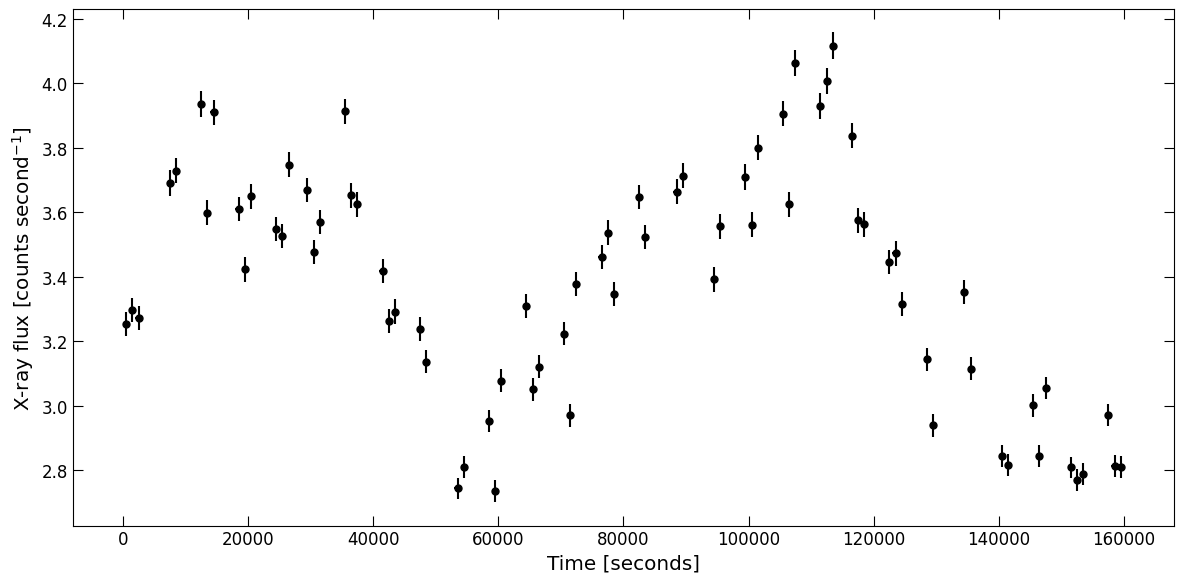

In [2]:
# Read in the FPMA data
bblc_A = LightCurve()
bblc_A.readFITS(srcFile='all_lcs/45_1210_A_sr.lc', bkgFile='all_lcs/45_1210_A_bk.lc')

# Read in the FPMB data
bblc_B = LightCurve()
bblc_B.readFITS(srcFile='all_lcs/45_1210_B_sr.lc', bkgFile='all_lcs/45_1210_B_bk.lc')

# Clean the data
min_fracexp = 1.0
bblc_A.clean(min_fracexp=min_fracexp)
bblc_B.clean(min_fracexp=min_fracexp)

# Merge the FPMA and FPMB data (sum the count rates)
bblc = merge_LightCurves(bblc_A, bblc_B)

# Bin the merged light curve to increase signal-to-noise ratio
dt = 1000
bblc.bin(dt=dt)

# Plot the light curve
bblc.plot()

Since NuSTAR orbits the Earth every ~90 minutes, for typical observations there are regular gaps in the light curve as NuSTAR travels behind the Earth. This is very problematic when it comes to Fourier techniques, as those methods require continuous time series. To get around this, we interpolate over the gaps by using Gaussian process regression. This will allow us to sample continuous light curves based on our observed light curve, which is used as the training data. Note that finer binning schemes will significantly increase the run-time of this step. The time binning should be selected to be as fine as possible while still maintaining a good signal-to-noise ratio. For our purposes, binning to 400 seconds will be sufficient. With our Gaussian process regression complete, we can produce a sample continuous light curve and plot it alongside our observed light curve for comparison.

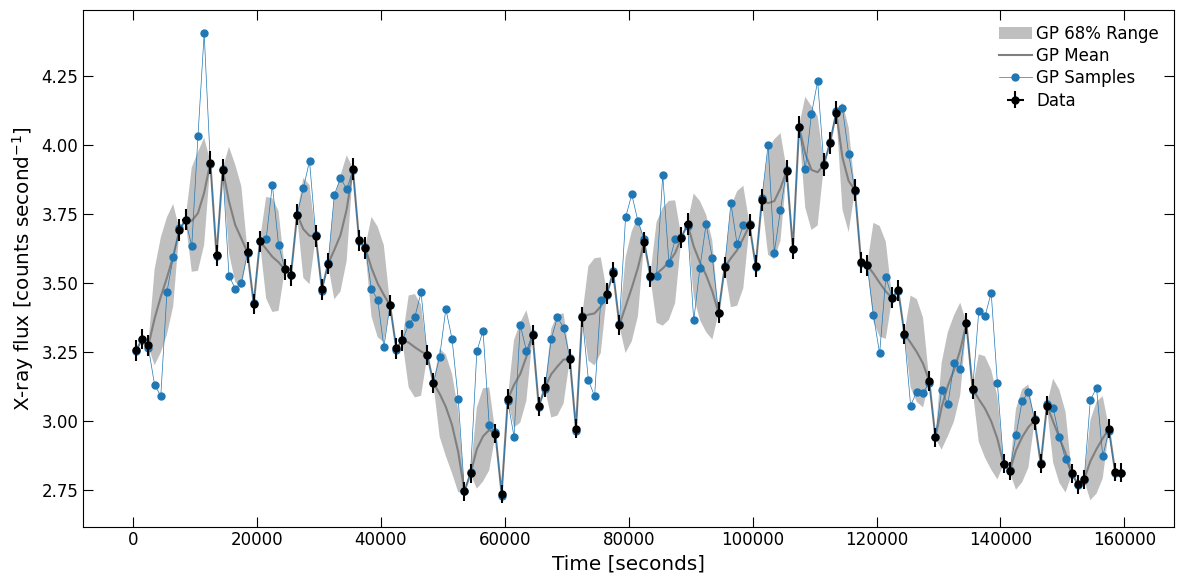

In [3]:
bblc.fit_gp()
bblc.sample_gp(nsamples=1)
bblc.plot()

Now, using the GP hyperparameters determined by our fit to the broad band light curve, we can apply the GP regression to the power law and Fe dominated emission bands.

In [4]:
# Produce the power law lght curve and GP samples
pllc_A = LightCurve()
pllc_A.readFITS(srcFile='all_lcs/po_A_sr.lc', bkgFile='all_lcs/po_A_bk.lc')
pllc_B = LightCurve()
pllc_B.readFITS(srcFile='all_lcs/po_B_sr.lc', bkgFile='all_lcs/po_B_bk.lc')
pllc_A.clean(min_fracexp=min_fracexp)
pllc_B.clean(min_fracexp=min_fracexp)
pllc = merge_LightCurves(pllc_A, pllc_B)
pllc.bin(dt=dt)
pllc.fit_gp(hyperparameters=bblc.gp_hyperparameters)


# Produce the Fe lght curve and GP samples
Felc_A = LightCurve()
Felc_A.readFITS(srcFile='all_lcs/Fe_A_sr.lc', bkgFile='all_lcs/Fe_A_bk.lc')
Felc_B = LightCurve()
Felc_B.readFITS(srcFile='all_lcs/Fe_B_sr.lc', bkgFile='all_lcs/Fe_B_bk.lc')
Felc_A.clean(min_fracexp=min_fracexp)
Felc_B.clean(min_fracexp=min_fracexp)
Felc = merge_LightCurves(Felc_A, Felc_B)
Felc.bin(dt=dt)
Felc.fit_gp(hyperparameters=bblc.gp_hyperparameters)

83 data points were                       cleaned from the FPMA data
84 data points were                       cleaned from the FPMB data
83 data points were                       cleaned from the FPMA data
84 data points were                       cleaned from the FPMB data


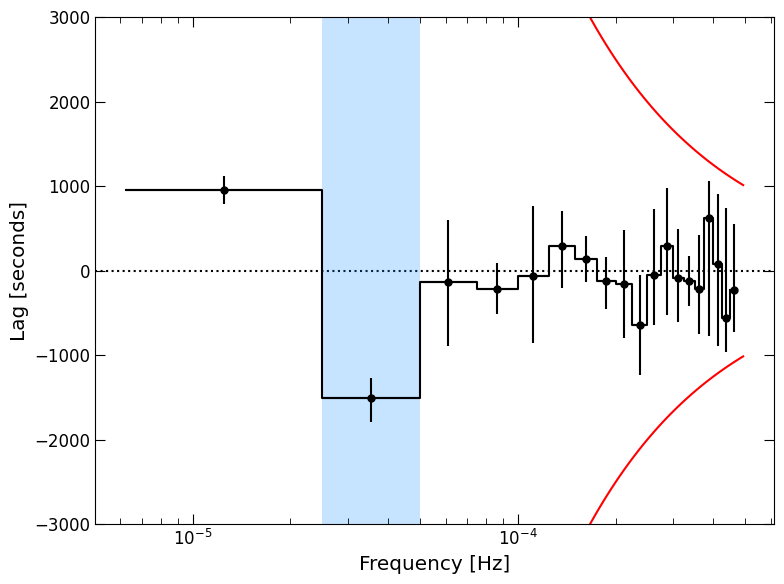

In [6]:
pllc.sample_gp(nsamples=1000)
Felc.sample_gp(nsamples=1000)
cs = CrossSpectrum(Felc, pllc)
cs.lagfreq_spectrum(start_idx=3, num_points=4)
min_freq = 2.5e-5
max_freq = 5.0e-5
cs.plot_lagfreq(min_freq=min_freq, max_freq=max_freq, plot_gp_samples=False, plot_allfreqs=False, yrange=3e3)

Now, we can read in the light curves for multiple energy bands to compute their lags against the broad band reference light curve in a specified frequency range of interest. This will produce a lag-energy spectrum, allowing us to visualize the evolution of any interesting frequency-resolved features in the lag-frequency spectrum now as a function of energy.

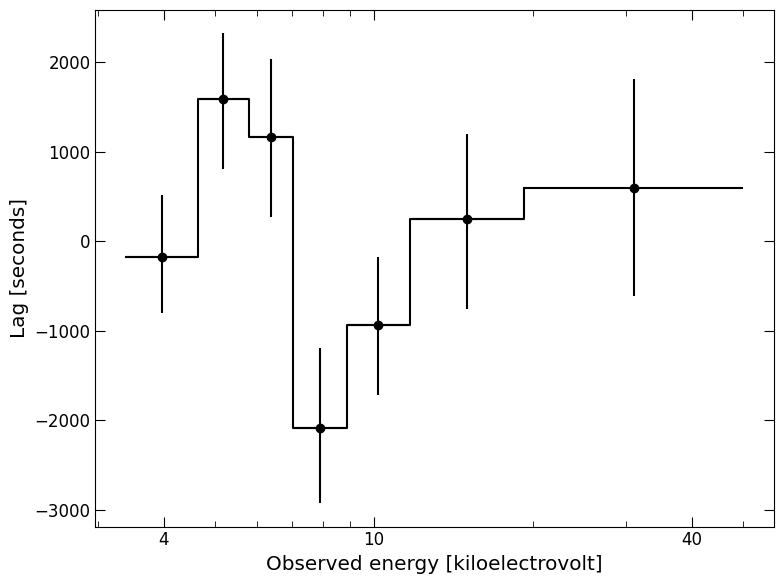

In [ ]:
lagenergy = LagEnergySpectrum()
lagenergy.loadLightCurves(refFile="all_lcs/reflc_bin.dat", ciFile="all_lcs/laglcs_bins.dat", inDir="all_lcs", dt=400, n_gp_samples=1000)
lagenergy.compute_lag(min_freq=2.5e-5, max_freq=5.0e-5)
lagenergy.plot()